In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# output 1심장마비 위험도 높고, 0은 낮다
# trdbps 휴식시 혈압, chol 콜레스테롤, fbs 공복혈당, restecg 휴식시 심전도(1파형이상2좌심실비대), thalach 최대심박수
# exang 운동 유발 협심증, oldpeak (파형이상)휴식시 심장변화, slp 말하기증상(2심함), caa 주요혈관 수, thall 빈혈
heart = pd.read_csv('./src/heart.csv')
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [2]:
heart['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

In [13]:
# sns.pairplot(heart, hue='output')
# plt.show()

<Axes: >

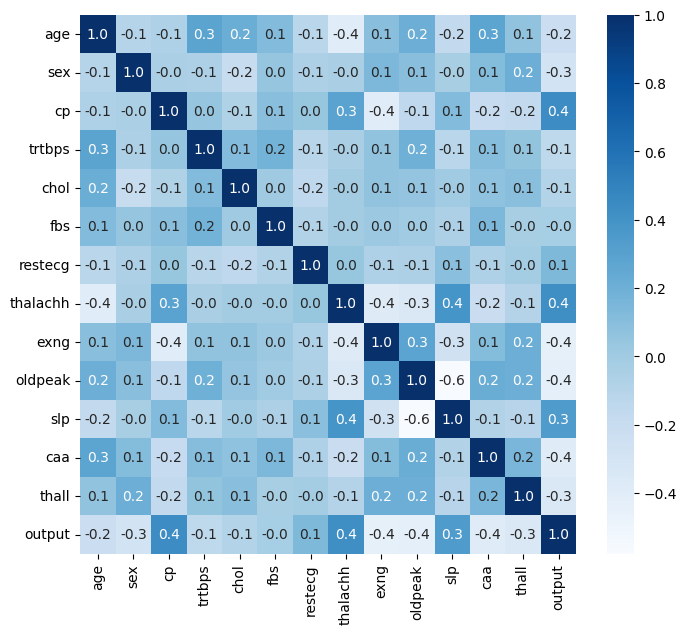

In [17]:
plt.figure(figsize=(8,7))
sns.heatmap(heart.corr(), annot=True, fmt='.1f', cmap='Blues')

In [10]:
heart.corr()['output'].abs().sort_values(ascending=False)

output      1.000000
exng        0.436757
cp          0.433798
oldpeak     0.430696
thalachh    0.421741
caa         0.391724
slp         0.345877
thall       0.344029
sex         0.280937
age         0.225439
trtbps      0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: output, dtype: float64

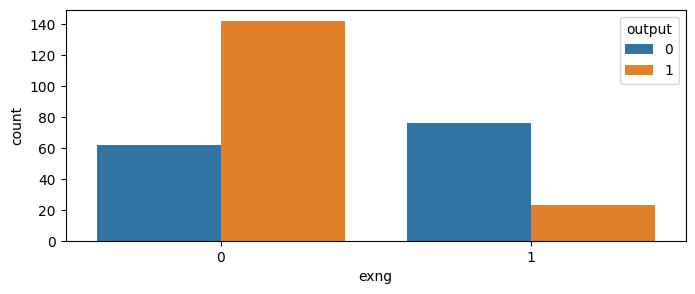

In [11]:
plt.figure(figsize=(8, 3))
sns.countplot(x='exng', hue='output', data=heart)
plt.show()

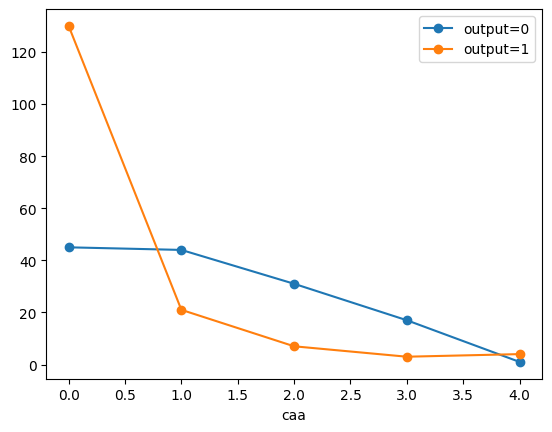

In [172]:
# plt.figure(figsize=(8, 5))
# sns.countplot(x='caa', hue='output', data=heart)
# plt.show()

heart[heart['output'] == 0].groupby('caa')['output'].count().plot(kind='line', marker='o', label='output=0')
heart[heart['output'] == 1].groupby('caa')['output'].count().plot(kind='line', marker='o', label='output=1')
plt.legend()
plt.show()

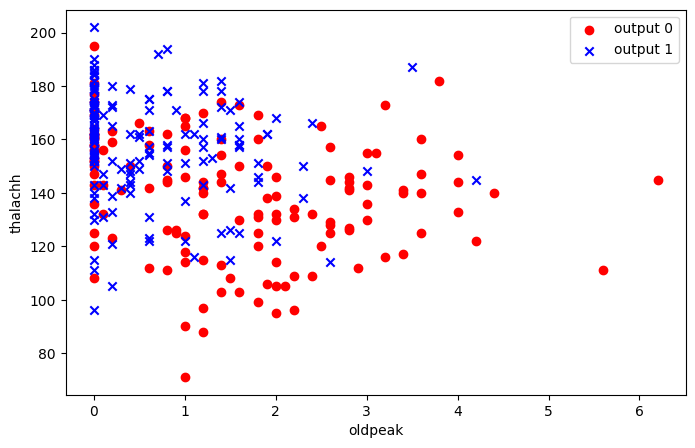

In [182]:
# oldpeak     0.430696
# thalachh    0.421741
# caa         0.391724
plt.figure(figsize=(8, 5))

heart_0 = heart[heart['output'] == 0]
heart_1 = heart[heart['output'] == 1]

plt.scatter(x='oldpeak', y='thalachh', c='red', data=heart_0, label='output 0')
plt.scatter(x='oldpeak', y='thalachh', c='blue', data=heart_1, label='output 1', marker='x')

plt.xlabel('oldpeak')
plt.ylabel('thalachh')
plt.legend()
plt.show()


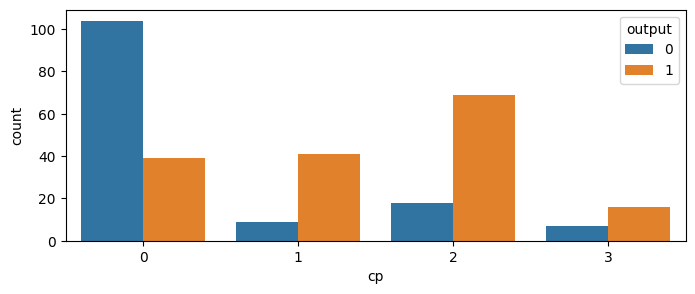

In [12]:
plt.figure(figsize=(8, 3))
sns.countplot(x='cp', hue='output', data=heart)
plt.show()

In [136]:
# output      1.000000
# exng        0.436757
# cp          0.433798
# oldpeak     0.430696
# thalachh    0.421741
# caa         0.391724
# slp         0.345877
# thall       0.344029
# sex         0.280937
# age         0.225439
# trtbps      0.144931
# restecg     0.137230
# chol        0.085239
# fbs         0.028046

X = heart.iloc[:, :-1]
y = heart.iloc[:, -1]

X = X.drop(['trtbps', 'restecg', 'chol', 'fbs', 'age', 'sex'], axis=1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train

,cp,thalachh,exng,oldpeak,slp,caa,thall
12,1,171,0,0.6,2,0,2
4,0,163,1,0.6,2,0,2
128,2,169,0,0.1,1,0,2
101,3,145,0,4.2,0,0,3
301,0,115,1,1.2,1,1,3
...,...,...,...,...,...,...,...
28,2,157,0,0.8,2,1,2
265,0,132,1,0.1,2,1,2
31,0,140,0,0.4,2,0,3
198,0,99,1,1.8,1,2,3


In [139]:
std = StandardScaler()
std_scaler_col = ['thalachh']
X_train[std_scaler_col] = std.fit_transform(X_train[std_scaler_col])
X_test[std_scaler_col] = std.transform(X_test[std_scaler_col])

mM_scaler = MinMaxScaler()
mM_scaler_col = ['oldpeak', 'caa', 'thall', 'slp', 'cp']
X_train[mM_scaler_col] = mM_scaler.fit_transform(X_train[mM_scaler_col])
X_test[mM_scaler_col] = mM_scaler.transform(X_test[mM_scaler_col])

X_train

,cp,thalachh,exng,oldpeak,slp,caa,thall
12,0.333333,0.950666,0,0.142857,1.0,0.00,0.666667
4,0.000000,0.604058,1,0.142857,1.0,0.00,0.666667
128,0.666667,0.864014,0,0.023810,0.5,0.00,0.666667
101,1.000000,-0.175811,0,1.000000,0.0,0.00,1.000000
301,0.000000,-1.475591,1,0.285714,0.5,0.25,1.000000
...,...,...,...,...,...,...,...
28,0.666667,0.344102,0,0.190476,1.0,0.25,0.666667
265,0.000000,-0.739049,1,0.023810,1.0,0.25,0.666667
31,0.000000,-0.392441,0,0.095238,1.0,0.00,1.000000
198,0.000000,-2.168808,1,0.428571,0.5,0.50,1.000000


In [150]:
from sklearn.model_selection import GridSearchCV

rf_pipe = make_pipeline(RandomForestClassifier(criterion='gini', random_state=1, n_jobs=-1))
param_grid = {'randomforestclassifier__n_estimators': [100, 300, 500],
              'randomforestclassifier__max_depth': [2, 4, 6, 8],
              'randomforestclassifier__min_samples_split': [2, 4, 6],
              'randomforestclassifier__min_samples_leaf': [1, 2, 4]}

gs = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [151]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

In [152]:
gs.best_score_

0.8308333333333333

In [153]:
gs.best_estimator_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_split=6,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=1))])

In [154]:
gs.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 6,
 'randomforestclassifier__n_estimators': 500}

In [155]:
forest = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=500, random_state=1, n_jobs=-1,
                                            min_samples_split=6, min_samples_leaf=1)
model = forest.fit(X_train, y_train)
p_val = forest.predict(X_test)
score = f1_score(y_test, p_val)

print('Best F1-score:', score)

Best F1-score: 0.8888888888888888


In [156]:
# 모델 평가
p_test = forest.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.8888888888888888
[[21  7]
 [ 1 32]]


# 교차검증

In [147]:
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.8308333333333333
1번 : 0.88
2번 : 0.72
3번 : 0.8333333333333334
4번 : 0.9166666666666666
5번 : 0.9166666666666666
6번 : 0.8333333333333334
7번 : 0.9166666666666666
8번 : 0.7083333333333334
9번 : 0.625
10번 : 0.9583333333333334


# 학습곡선

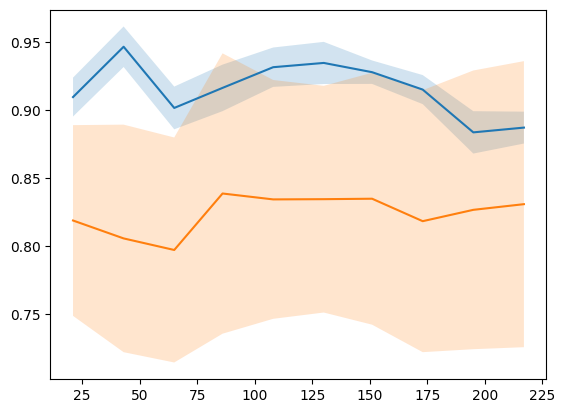

In [148]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=model, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

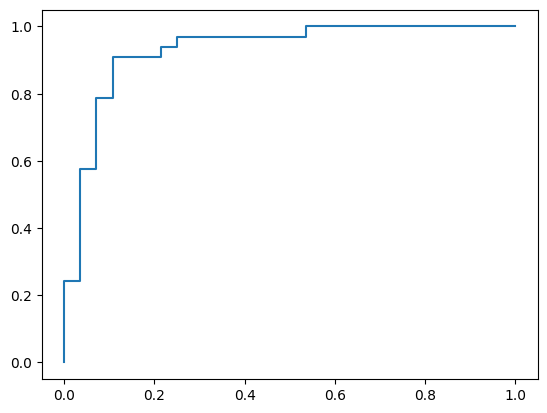

In [149]:
prob = forest.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.show()

In [126]:
svc_pipe = make_pipeline(SVC(kernel='rbf', random_state=1))
param_grid = {'svc__C': [0.1, 1, 10, 100],
              'svc__gamma': [0.1, 1, 10, 100]}

gs = GridSearchCV(estimator=svc_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [127]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

In [128]:
gs.best_score_

0.8056666666666666

In [129]:
gs.best_estimator_

Pipeline(steps=[('svc', SVC(C=100, gamma=0.1, random_state=1))])

In [130]:
svc_model = SVC(kernel='rbf', random_state=1, C=100, gamma=0.1)
svc_model.fit(X_train, y_train)

SVC(C=100, gamma=0.1, random_state=1)

In [131]:
model = svc_model.fit(X_train, y_train)
p_val = svc_model.predict(X_test)
score = f1_score(y_test, p_val)

print('Best F1-score:', score)

Best F1-score: 0.8333333333333334


In [135]:
# 모델 평가
p_test = svc_model.predict(X_test)
print('F1-score:', f1_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))

F1-score: 0.8333333333333334
[[19 11]
 [ 1 30]]


In [132]:
cvscore = cross_val_score(estimator=svc_model, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.8056666666666666
1번 : 0.8
2번 : 0.84
3번 : 0.6666666666666666
4번 : 0.7916666666666666
5번 : 0.75
6번 : 0.875
7번 : 0.9583333333333334
8번 : 0.875
9번 : 0.75
10번 : 0.75


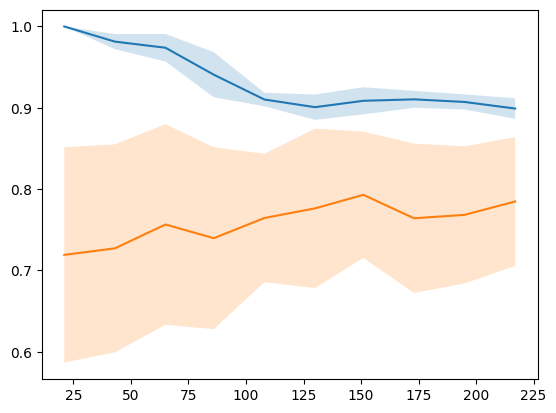

In [133]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=model, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

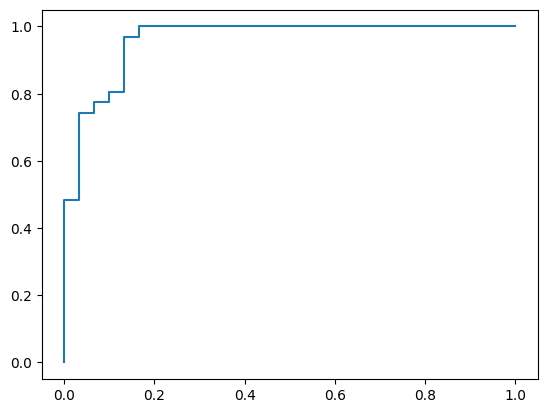

In [134]:
prob = forest.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, prob[:,1])
roc_auc_score(y_test, prob[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.show()